# Проект: классификация

!!! В данном коде учтены контрольные ответы на вопросы обучающей платформы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

**Данные о клиентах банка:**
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

**Прочие признаки:**
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

**Целевая переменная deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.


### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [6]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_replace(x):
  x = str(x)
  x = x.replace(' ', '')
  x = x.replace(',00$', '')
  x = x.replace('$', '')
  x = float(x)
  return x

df['balance'] = df['balance'].apply(balance_replace)

In [8]:
print(f'Средний balance: {round(df.balance.mean(), 3)}')

Средний balance: 1529.129


### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
balance_median = df['balance'].median()
df.loc[(df['balance'].isnull() == True), 'balance'] = balance_median

In [10]:
print(f'Средний balance после преобразования: {round(df.balance.mean(), 3)}')

Средний balance после преобразования: 1526.936


### Задание 5

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_mode = df['job'].mode()
education_mode = df['education'].mode()
df.loc[(df['job'] == 'unknown'), 'job'] = job_mode[0]
df.loc[(df['education'] == 'unknown'), 'education'] = education_mode[0]

In [12]:
balance_mean_pop = df[(df['job'] == job_mode[0]) & 
                      (df['education'] == education_mode[0])]['balance'].mean()
print(f'Средний balance с самой популярной работой и образованием: {round(balance_mean_pop, 3)}')

Средний balance с самой популярной работой и образованием: 1598.883


### Задание 6

In [13]:
# удалите все выбросы для признака balance

In [14]:
perc_75 = np.percentile(df['balance'], 75)
perc_25 = np.percentile(df['balance'], 25)
IQR = perc_75 - perc_25
low_limit = perc_25 - 1.5 * IQR
hight_limit = perc_75 + 1.5 * IQR

In [15]:
print(f'Нижняя граница: {round(low_limit, 0)}')
print(f'Верхняя граница: {round(hight_limit,0)}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0


In [16]:
df = df[df['balance'].between(low_limit, hight_limit)]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

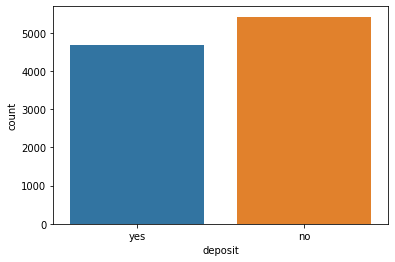

In [18]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(df['deposit'].value_counts())
sns.countplot(data=df, x='deposit');

Как видим, целевая переменная распределена сбалансировано

### Задание 2

In [19]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fe9ba9fd0>,
      dtype=object)

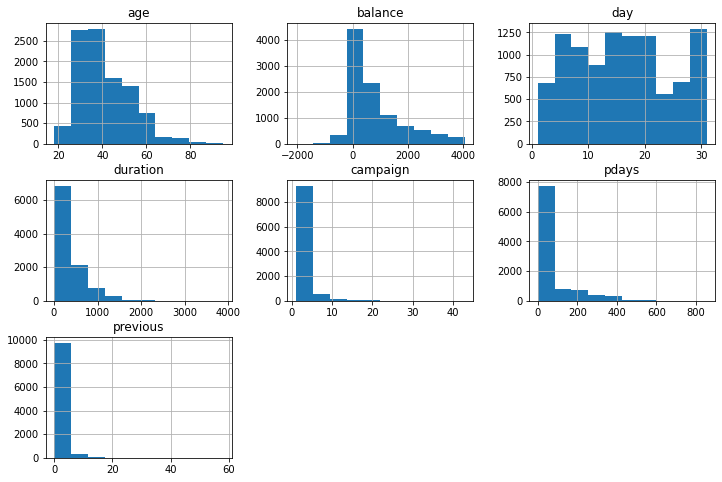

In [20]:
df.hist(figsize=(12,8))

**Age:**
средний возраст клиентов - 41 год. Минимальный возраст - 18 лет, максимальный - 95

**Balance:**
средний баланс около 800 долларов, судя по гистограмме основная доля клиентов с небольшим балансом. Минимальное значение баланса - 2049 долларов, т.е. есть клиенты-должники. Стандарное отклонение больше среднего значения,  таким образом, выборка сильно вариабельна.

Признаки **duration, campaign, pdays, previous** - на гистограммах видно, что большое количество значений - около нулевые значения. Данные признаки мало значимы для целевой переменной

### Задание 3

In [21]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


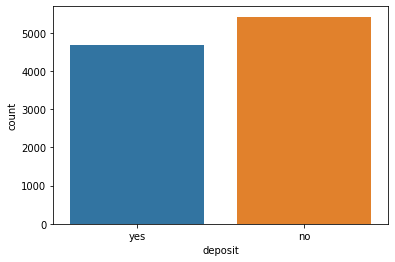

In [22]:
sns.countplot(data=df, x='deposit');

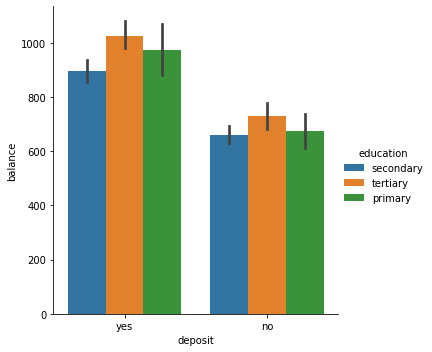

In [23]:
sns.catplot(x = "deposit", y = 'balance', hue = "education", kind = "bar", data = df);

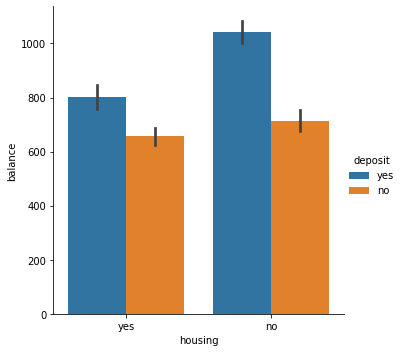

In [24]:
sns.catplot(x = "housing", y = 'balance', hue = "deposit", kind = "bar", data = df);

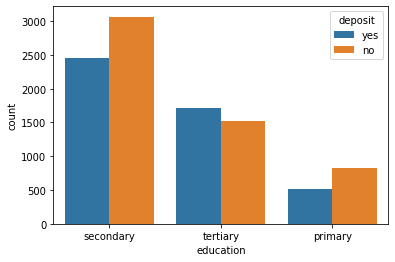

In [25]:
sns.countplot(data=df, x='education', hue = "deposit");

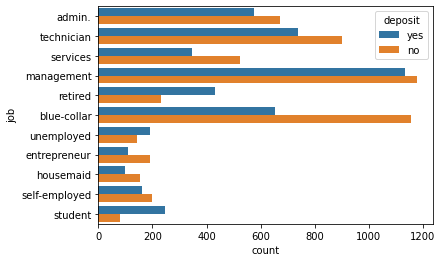

In [26]:
sns.countplot(data=df, y='job', hue = "deposit", );

Управленцы в 2 раза чаще соглашаются на открытие депозита, чем рабочие. Студенты чаще соглашаются на открытие депозита, чем отказываются.

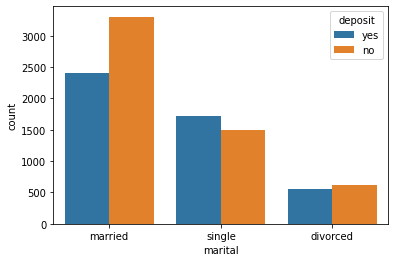

In [27]:
sns.countplot(data=df, x='marital', hue = "deposit", );

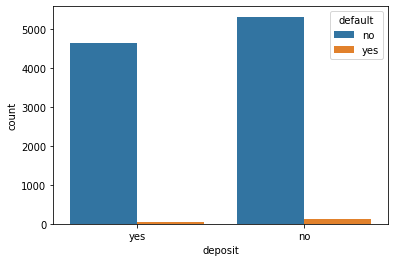

In [28]:
sns.countplot(data=df, x='deposit', hue = "default", );

Как видим, клиенты банка практически не имеют задолженности по кредитам

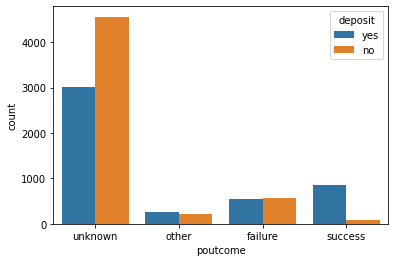

In [29]:
sns.countplot(data=df, x='poutcome', hue = "deposit", );

In [30]:
df.poutcome.value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

### Задание 4

In [31]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 5

In [35]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df1 = df[['month', 'deposit']].copy()

In [40]:
(df1.groupby('month')['deposit'].value_counts(normalize=True).unstack() \
  * 100).sort_values('no', ascending=False)

deposit,no,yes
month,,
may,67.863966,32.136034
jan,60.815047,39.184953
jul,58.956276,41.043724
nov,58.461538,41.538462
aug,55.956679,44.043321
jun,54.891304,45.108696
feb,45.557123,54.442877
apr,38.192771,61.807229
oct,18.507463,81.492537


### Задание 6

In [41]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
'''
      1:  <30
      2:  30-40
      3:  40-50
      4:  50-60
      5:  >60
'''
df3 = df.copy()

In [42]:
def age_groups(age):
  if age < 30:
    return '<30'
  elif (age >= 30) & (age < 40):
    return '30-40'
  elif (age >= 40) & (age < 50):
    return '40-50'
  elif (age >= 50) & (age < 60):
    return '50-60'
  elif age >= 60:
    return '60+'

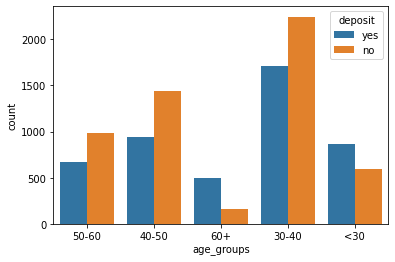

In [43]:
df3['age_groups'] = df3['age'].apply(age_groups)
sns.countplot(data=df3, x='age_groups', hue = "deposit", );

In [ ]:
# еще одини вариант разбить на группы признак "age"
#df3['age_group3'] = pd.cut(df3.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

### Задание 7

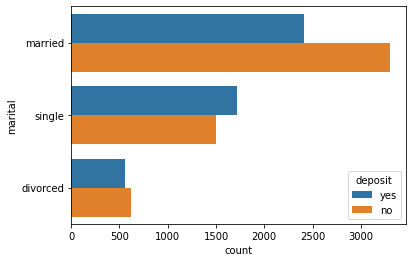

In [44]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(data=df, y='marital', hue = "deposit", );

Неженатые/незамужние более склонны к открытию депозита, чем семейные.

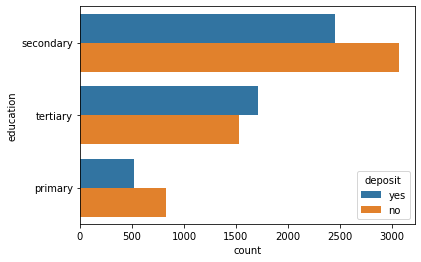

In [45]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(data=df, y='education', hue = "deposit", );

Большинство клиентов банка  - со средним образованием. Более склонны к открытию депозита клиенты с высшим образованием.

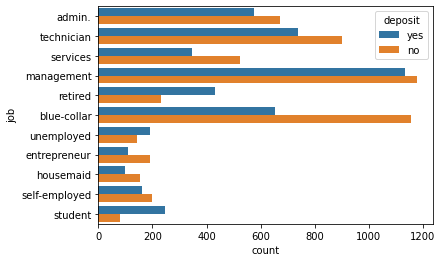

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(data=df, y='job', hue = "deposit", );

Более склонны (процент согласия на открытие депозита) к открытию - это пенсионеры и студенты. Самые многочисленные группы клиентов банка - это упраавленцы, рабочие и имеющие техническое образование

### Задание 8

In [51]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df4 = df.copy()
df4 = df4[df4.deposit == 'yes']
result_yes = df4.groupby('education')['marital'].value_counts(normalize=False).unstack()

In [52]:
df5 = df.copy()
df5 = df5[df5.deposit == 'no']
result_no = df5.groupby('education')['marital'].value_counts(normalize=False).unstack()

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


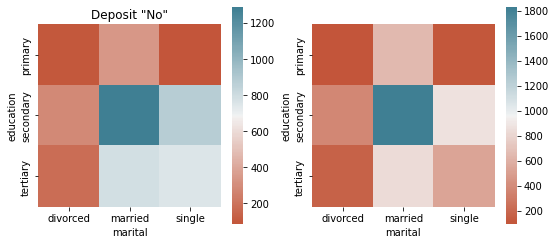

In [60]:
display(result_yes, result_no)
fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(result_yes, ax=ax[0], cmap=sns.diverging_palette(20, 220, n=200),
            square=True,)
ax[0].set_title('Deposit "Yes"')
sns.heatmap(result_no , ax=ax[1], cmap=sns.diverging_palette(20, 220, n=200),
            square=True,)
ax[0].set_title('Deposit "No"');

In [61]:
# еще один вариант сводной таблицы с возможностью построения тепловой карты
# df4 = df[df.deposit == 'yes'][['education','marital','deposit']]
# df5 = df[df.deposit == 'no'][['education','marital','deposit']] 
# result_yes = pd.crosstab(df4['education'],bank1['marital']) # таблица сопряженности
# result_no = pd.crosstab(df5['education'],bank2['marital'])

## Часть 3: преобразование данных

### Задание 1

In [62]:
# преобразуйте уровни образования
df6 = df.copy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df6['education'] = label_encoder.fit_transform(df['education'])

In [63]:
df6['education'].sum()

11995

In [65]:
# преобразуйте порядковую переменную для возраста
df6['age_groups'] = label_encoder.fit_transform(df3['age_groups'])

### Задание 2

In [66]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df7 = df6.copy()

In [67]:
df7['deposit'] = df7['deposit'].apply(lambda x: 1 if x == "yes" else 0)
df7['default'] = df7['default'].apply(lambda x: 1 if x == "yes" else 0)
df7['housing'] = df7['housing'].apply(lambda x: 1 if x == "yes" else 0)
df7['loan'] = df7['loan'].apply(lambda x: 1 if x == "yes" else 0)

In [68]:
print(f'Cтандартное отклонение: {round(df7.deposit.std(), 3)}')

Cтандартное отклонение: 0.499


In [69]:
a = df7['default'].mean()
b = df7['housing'].mean()
c = df7['loan'].mean()

In [70]:
print(f'Сумма средних арифметических: {round(a + b + c, 3)}')

Сумма средних арифметических: 0.635


### Задание 3

In [71]:
# создайте дамми-переменные
df8 = df7[['job', 'marital', 'contact', 'month', 'poutcome']]
df8 = pd.get_dummies(df8, prefix=['job', 'marital', 'contact', 'month', 'poutcome'])
df9 = pd.concat([df7, df8], axis = 1)

In [72]:
# Удалим признаки типа object
mask = []
for col in df9.columns:
  if df9[col].dtype == 'object':
    print(f'Столбец: {col}')
    mask.append(col)


Столбец: job
Столбец: marital
Столбец: contact
Столбец: month
Столбец: poutcome


In [73]:
df9 = df9.drop(mask, axis=1)
df9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_groups         10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

In [ ]:
# еще вариант удаления столбцов с типом object
# mask = df9.select_dtypes('object').columns
# df9.drop(columns=mask, inplace=True)

In [74]:
df9.shape

(10105, 46)

### Задание 4

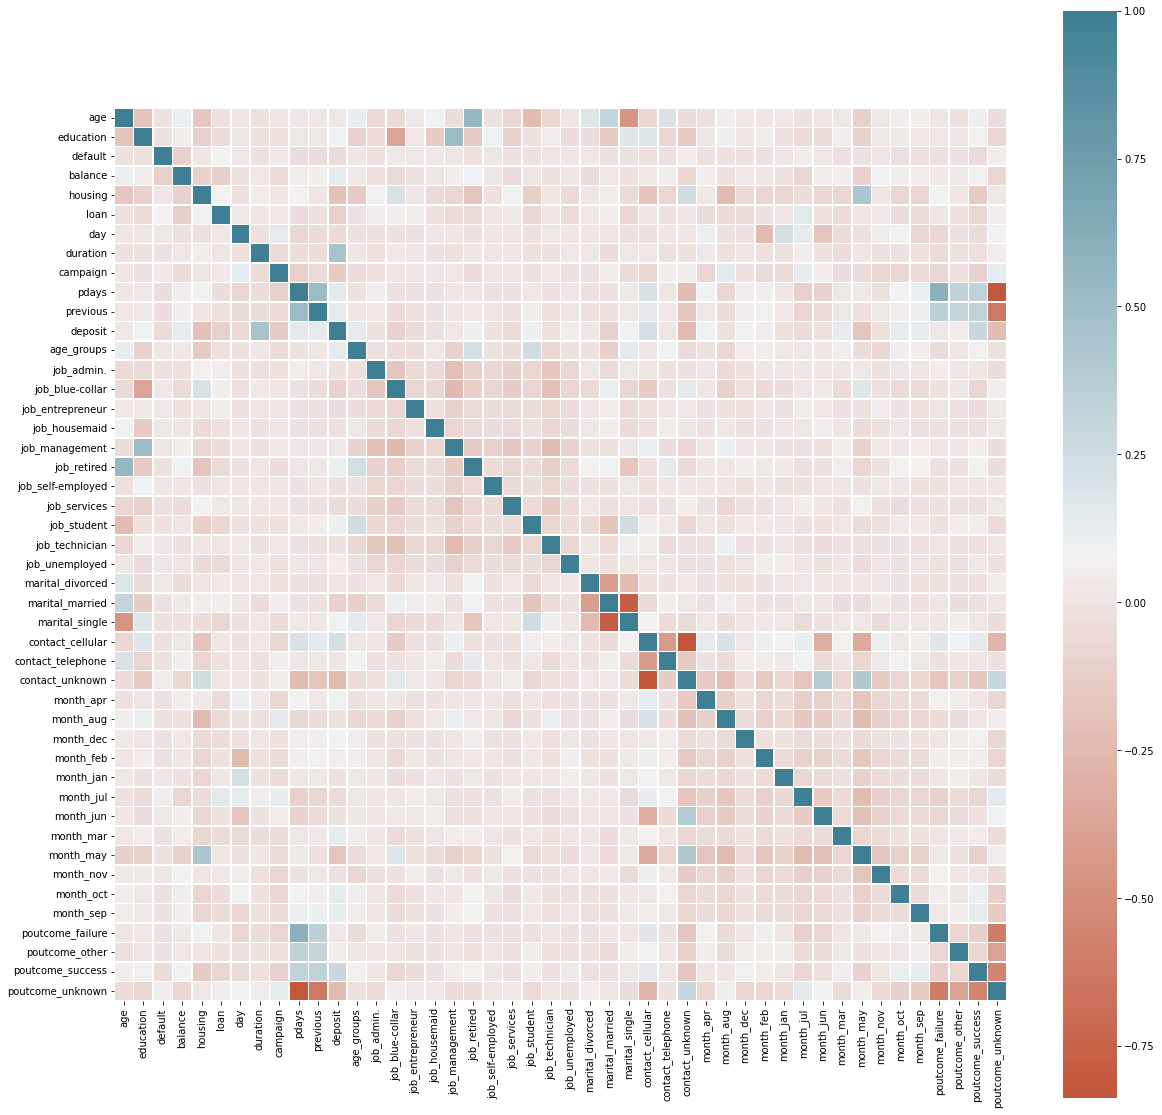

In [76]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = df9.corr()
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(corr, 
            cmap = sns.diverging_palette(20, 220, n = 200),
            square = True,
            linewidths = 0.5)

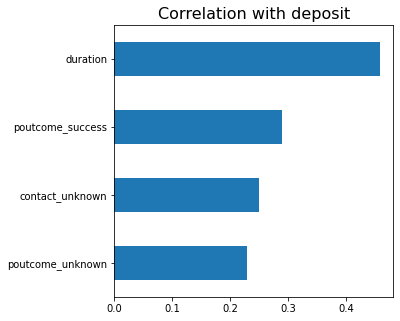

In [80]:
# Для ранжирования коэффициентов корреляции
plt.rcParams['figure.figsize'] = (5,5)
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

### Задание 5

In [82]:
X = df9.drop(['deposit'], axis=1)
y = df9['deposit']
# Разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state = 42, test_size = 0.33)

In [83]:
# рассчитайте необходимые показатели
y_test.shape

(3335,)

In [84]:
print(f'Cреднее значение целевой переменной: {round(y_test.mean(), 2)}')

Cреднее значение целевой переменной: 0.46


### Задание 6

In [116]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
feature_names = selector.get_feature_names_out()
feature_names

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_groups', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [86]:
# оставим в датафрейме только наиболее подходящие признаки + целевую переменную
df10 = df9[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_groups', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'deposit']]

In [88]:
# разбивка выборок
X = df10.drop(['deposit'], axis=1)
y = df10['deposit']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 7

In [89]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [90]:
print(f'среднее арифметическое для первого предиктора: {round(X_test_scaled[:,0].mean(),2)}')

среднее арифметическое для первого предиктора: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [91]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag',
                                          random_state=42,
                                          max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [92]:
y_pred = log_reg.predict(X_test_scaled)

In [93]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



In [94]:
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.80


### Задание 2

In [95]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                     random_state=42,
                                     max_depth = 6,
                                     )
dt_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [98]:
#Делаем предсказание для каждой из выборок
y_train_pred = dt_clf.predict(X_train_scaled)
y_test_pred = dt_clf.predict(X_test_scaled)
#Выводим значения метрик для тренировочной выборки
print('Train accuracy-score: {:.2f}'.format(
    metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для тестовой выборки
print('Test accuracy-score: {:.2f}'.format(
    metrics.accuracy_score(y_test, y_test_pred)))

Train accuracy-score: 0.82
Test accuracy-score: 0.81


In [97]:
y_pred = dt_clf.predict(X_test_scaled)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 3

In [99]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

In [100]:
# сетка-словарь гиперпараметров
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

In [101]:
%time 
grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(
    grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [102]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=42,
    )
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [104]:
#Выводим значения метрики 
y_test_pred = rf.predict(X_test_scaled)
print('accuracy_score на тестовом наборе: {:.2f}'.format(
    metrics.accuracy_score(y_test, y_test_pred)))
print('recall_score на тестовом наборе: {:.2f}'.format(
    metrics.recall_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
y_train_pred = rf.predict(X_train_scaled)
print('f1_score на тренировочном наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print(metrics.classification_report(y_test, y_test_pred))

accuracy_score на тестовом наборе: 0.83
recall_score на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
f1_score на тренировочном наборе: 0.85
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

In [106]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [107]:
y_test_pred = gb.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
y_train_pred = gb.predict(X_train_scaled)
print('f1_score на тренировочном наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print(metrics.classification_report(y_test, y_pred))

f1_score на тестовом наборе: 0.82
f1_score на тренировочном наборе: 0.88
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание3

In [110]:
# объедините уже известные вам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000,
        )
    ),
    ('dt', tree.DecisionTreeClassifier(
        criterion = 'entropy',
        max_depth = 7,
        min_samples_split = 2,
        random_state=42,
        )
    ),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42,
        )
    )
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators = estimators,
    final_estimator = linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000,
        )
)


In [112]:
#Обучаем модель
%%time
reg.fit(X_train_scaled, y_train)

CPU times: user 21.4 s, sys: 298 ms, total: 21.7 s
Wall time: 22.5 s


StackingClassifier(estimators=[('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
            

In [113]:
y_pred_stack = reg.predict(X_test_scaled)
print('f1_precision на тестовом наборе: {:.2f}'.format(
    metrics.precision_score(y_test, y_pred_stack)))

f1_precision на тестовом наборе: 0.80


### Задание 4

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5, 
    max_depth=5,
    random_state=42)
gb.fit(X_train_scaled, y_train)

In [125]:
feature_impotant = list(zip(feature_names, gb.feature_importances_))
feature_impotant.sort(key = lambda x: x[1], reverse = True)
feature_impotant

[('duration', 0.5019868598741398),
 ('poutcome_success', 0.11626370100249665),
 ('contact_unknown', 0.07376167754018609),
 ('balance', 0.059764354955215114),
 ('pdays', 0.05569026026051745),
 ('housing', 0.04658336768248359),
 ('age_groups', 0.04210175349754446),
 ('month_mar', 0.026144241513862645),
 ('month_oct', 0.018823711273960046),
 ('campaign', 0.017100726266917974),
 ('month_may', 0.014507747393188967),
 ('month_sep', 0.013427506066882507),
 ('previous', 0.008857456502826521),
 ('contact_cellular', 0.0046001369592528684),
 ('poutcome_unknown', 0.00038649921052513395)]

### Задание 5

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# Устанавливаем библиотеку
#!pip install optuna

In [127]:
import optuna
from sklearn.model_selection import cross_val_score

In [128]:
# зафксируем random_state
random_state = 42
def optuna_rf(trial, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # задаём модели требуемые параметры  
  model=ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        random_state=random_state)

  # проводим кросс-валидацию  
  score = cross_val_score(estimator=model, X=X, y=y, 
                          scoring='f1', cv=cv, n_jobs=-1).mean()

  return score

In [129]:
%%time
# cоздаем объект исследования
# напрямую указываем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-07-02 18:30:40,662] A new study created in memory with name: no-name-18bfe531-12e0-45d9-a7fc-3b9d1724372b
[I 2022-07-02 18:30:43,776] Trial 0 finished with value: 0.8194613227090194 and parameters: {'n_estimators': 106, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8194613227090194.
[I 2022-07-02 18:30:46,484] Trial 1 finished with value: 0.8227022613934061 and parameters: {'n_estimators': 151, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8227022613934061.
[I 2022-07-02 18:30:48,426] Trial 2 finished with value: 0.8260580301953675 and parameters: {'n_estimators': 105, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8260580301953675.
[I 2022-07-02 18:30:51,400] Trial 3 finished with value: 0.8237843250011803 and parameters: {'n_estimators': 170, 'max_depth': 11, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8260580301953675.
[I 2022-07-02 18:30:54,687] Trial 4 finished with value: 0.821346567313475

CPU times: user 1.04 s, sys: 118 ms, total: 1.16 s
Wall time: 1min


In [130]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 167, 'max_depth': 18, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.83


In [131]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,
                                        random_state=random_state)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("f1_score на обучающем наборе: {:.3f}".format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.888
f1_score на тестовом наборе: 0.817


In [132]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335




Выводы:

* Проведена предобработка данных.
* Проведен разведывательный анализ данных в контексте влияния на целевой признак.
* Проведено кодирование признаков (бинарное и LabelEncoder) и масштабирование значений (MinMaxScaler).
* С помощью ANOVA F-value (f_classif) для построения моделей отобраны 15 наиболее значимых признаков.
* Построены простые базовые модели - логистическая регрессия и решающее дерево.
* Построены ансамблевые модели - случайный лес, градиентный бустинг на решающих деревьх, стекинг из деревьев, регрессии и бустинга.
* Выполнен подбор гиперпараметров - поиск по сетке (GridSearchCV) и продвинутый (Optuna).
* При построении каждая модель оценивались с выводом метриков качества классификации. Как и ожидалось, ансамбли показывают лучшие значения метрик.
* Даны ответы на контрольные вопросы обучающей платформы
